In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

!pip install typeguard
from typeguard import typechecked
from typing import Optional

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/BME 2121 Mini Project/Dataset 1/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/BME 2121 Mini Project/Dataset 1/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab Notebooks/BME 2121 Mini Project/Dataset 1/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 2558 images belonging to 4 classes.


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=4))
model.add(Activation('softmax'))

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, 
                                                 beta_1=0.9, 
                                                 beta_2=0.999, 
                                                 epsilon=1e-07, 
                                                 amsgrad=False,
                                                 name='Adam',), 
              loss='categorical_crossentropy',
              metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs = 20,
                  verbose = 1,
                  callbacks=lr_scheduler)

Epoch 1/20
129/129 [==============================] - 646s 5s/step - loss: 3.0976 - accuracy: 0.7479 - precision: 0.4898 - recall: 0.1996 - auc: 0.7605 - f1_score: 0.1998 - val_loss: 1.0343 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7804 - val_f1_score: 0.0000e+00 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - 71s 547ms/step - loss: 1.0377 - accuracy: 0.7485 - precision: 0.4951 - recall: 0.2977 - auc: 0.7770 - f1_score: 0.2955 - val_loss: 1.0347 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7804 - val_f1_score: 0.5004 - lr: 0.0063
Epoch 3/20
129/129 [==============================] - 71s 553ms/step - loss: 1.0378 - accuracy: 0.7466 - precision: 0.4709 - recall: 0.1105 - auc: 0.7777 - f1_score: 0.1097 - val_loss: 1.0347 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.7804 - val_f1_score: 0.5006 - lr: 0.0040
Epoch 4/20
129/129 [============================

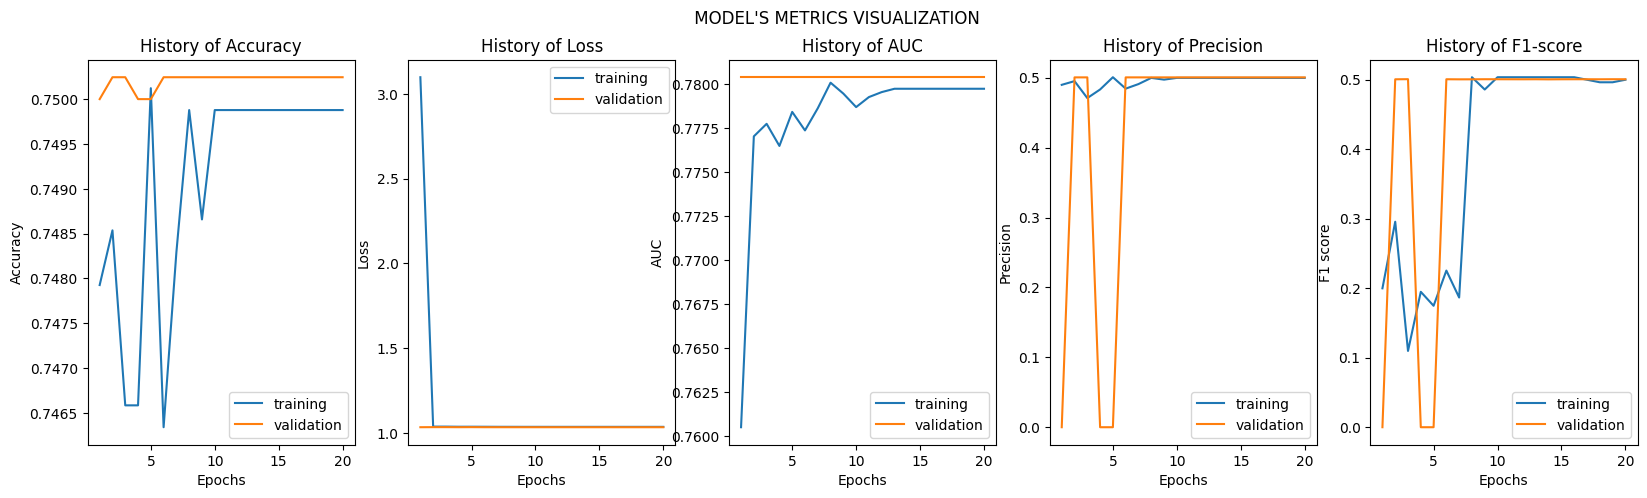

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate_generator(test_dataset)

<ipython-input-23-245a018ec215>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_dataset)


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7501954436302185
Precision =  0.5003909468650818
Recall =  0.5003909468650818
AUC =  0.7805577516555786
F1_score =  0.5002082586288452
